# MTH 9855 Homework 8

## Junliang Zhou

Tel: (347) 276-1207

Email: gjimzhou@gmail.com

In [1]:
# Setup environment
import numpy as np
import pandas as pd
import time
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define forecast and cost functions
def alpha(t, forecast, halflife):
    return 1e-4*forecast*2**(-t/halflife)

def cost(delta, P, gamma, sigma, V, Theta, eta, beta):
    X=delta/P
    return P*X*(gamma*sigma/2*X/V*(Theta/V)**0.25+np.sign(X)*eta*sigma*np.abs(X/V)**beta)

In [3]:
# Define minus utility function for optimization
def minusutility(x1, x0, t, kappa=1e-7, forecast=50, halflife=5, P=40, gamma=0.314, sigma=0.02, V=2e6, Theta=2e8, eta=0.142, beta=0.6):
    delta=x1-x0
    profits=x1*alpha(t, forecast, halflife)
    risks=kappa/2*sigma**2*x1**2
    costs=cost(delta, P, gamma, sigma, V, Theta, eta, beta)
    return -profits+risks+costs

In [4]:
# Define the optimizer
def optimizer(T=30, kappa=1e-7, forecast=50, halflife=5, P=40, gamma=0.314, sigma=0.02, V=2e6, Theta=2e8, eta=0.142, beta=0.6):
    times=np.arange(1,T+1)
    path=np.array([alpha(t, forecast, halflife)/(kappa*sigma**2) for t in times])
    path=np.insert(path,0,0)
    for t in times:
        res=optimize.minimize(minusutility, path[t], 
                              args=(path[t-1], t, kappa, forecast, halflife, P, gamma, sigma, V, Theta, eta, beta), 
                              method='Nelder-Mead', tol=1)
        path[t]=res.x
    return path

In [5]:
# Define the timer
def timeit(method):
    def timed(*args,**kw):
        ts = time.time()
        method(*args,**kw)
        te = time.time()
        return te-ts 
    return timed

@timeit
def optimizetimer(T=30, kappa=1e-7, forecast=50, halflife=5, P=40, gamma=0.314, sigma=0.02, V=2e6, Theta=2e8, eta=0.142, beta=0.6):
    return optimizer(T, kappa, forecast, halflife, P, gamma, sigma, V, Theta, eta, beta)

In [6]:
# Define profit and sharpe ratio functions
def profit(path, forecast=50, halflife=5, P=40, gamma=0.314, sigma=0.02, V=2e6, Theta=2e8, eta=0.142, beta=0.6):
    times=np.arange(path.shape[0])
    delta=np.diff(path)
    profits=np.array([x*alpha(t, forecast, halflife) for x,t in zip(path,times)])
    costs=np.array([cost(d, P, gamma, sigma, V, Theta, eta, beta) for d in delta])
    return np.sum(profits)-np.sum(costs)

def sharpe(path, forecast=50, halflife=5, P=40, gamma=0.314, sigma=0.02, V=2e6, Theta=2e8, eta=0.142, beta=0.6):
    ee=profit(path, forecast, halflife, P, gamma, sigma, V, Theta, eta, beta)
    vv=np.linalg.norm(path)*sigma
    return np.sqrt(252)*ee/vv

In [7]:
# Setup parameters
T=30
kappa=1e-7
forecast=50
halflife=5
P=40
gamma=0.314
sigma=0.02
V=2e6
Theta=2e8
eta=0.142
beta=0.6

times=np.arange(0,T+1)

In [8]:
# Get optimal path for default parameters
path=optimizer()

In [9]:
# Output path
pd.DataFrame({"Path":path})

,Path
0,0.000000e+00
1,1.045223e+07
2,1.824888e+07
3,2.393468e+07
4,2.795552e+07
5,3.067620e+07
6,3.239557e+07
7,3.336021e+07
8,3.377869e+07
9,3.384646e+07


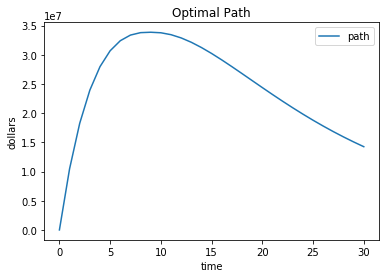

In [10]:
# Plot optimal path
plt.plot(times, path, label="path")
plt.title("Optimal Path")
plt.xlabel("time")
plt.ylabel("dollars")
plt.legend()

In [11]:
# Output computation time
optimizetimer()

0.18051528930664062

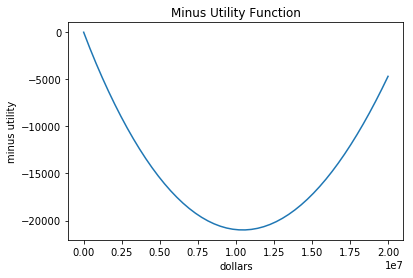

In [12]:
# Test the convexity of minusutility function
xs=np.linspace(0,2e7)
mus=np.array([minusutility(x,0,1) for x in xs])
plt.plot(xs,mus)
plt.title("Minus Utility Function")
plt.xlabel("dollars")
plt.ylabel("minus utility")

In [13]:
# Optimize against different kappas
kappas=np.array([2**x for x in range(-30,-15)])
profits=[]
sharpes=[]
for k in kappas:
    path=optimizer(kappa=k)
    profits.append(profit(path))
    sharpes.append(sharpe(path))

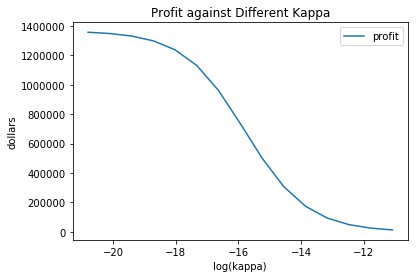

In [14]:
# Plot profit
plt.plot(np.log(kappas), profits, label="profit")
plt.title("Profit against Different Kappa")
plt.xlabel("log(kappa)")
plt.ylabel("dollars")
plt.legend()

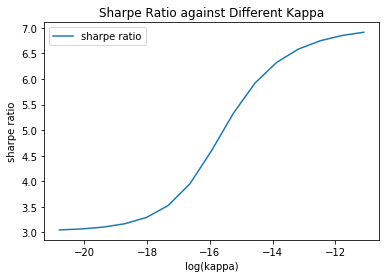

In [15]:
# Plot sparpe ratio
plt.plot(np.log(kappas), sharpes, label="sharpe ratio")
plt.title("Sharpe Ratio against Different Kappa")
plt.xlabel("log(kappa)")
plt.ylabel("sharpe ratio")
plt.legend()

In [16]:
# Optimize against different half lifes
halflifes=np.arange(1,61)
profits=[]
sharpes=[]
for h in halflifes:
    path=optimizer(halflife=h)
    profits.append(profit(path, halflife=h))
    sharpes.append(sharpe(path, halflife=h))

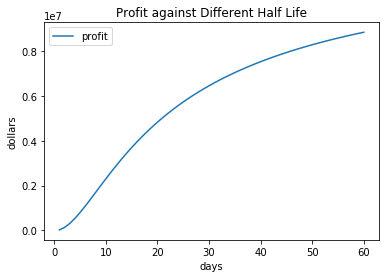

In [17]:
# Plot profit
plt.plot(halflifes, profits, label="profit")
plt.title("Profit against Different Half Life")
plt.xlabel("days")
plt.ylabel("dollars")
plt.legend()

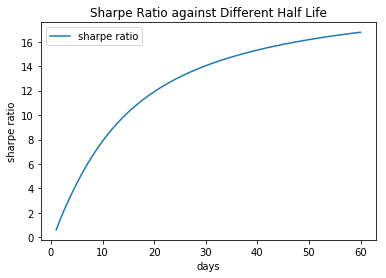

In [18]:
# Plot sparpe ratio
plt.plot(halflifes, sharpes, label="sharpe ratio")
plt.title("Sharpe Ratio against Different Half Life")
plt.xlabel("days")
plt.ylabel("sharpe ratio")
plt.legend()

In [19]:
# Optimize against different initial strengths
forecasts=np.arange(1,101)
profits=[]
sharpes=[]
for f in forecasts:
    path=optimizer(forecast=f)
    profits.append(profit(path, forecast=f))
    sharpes.append(sharpe(path, forecast=f))

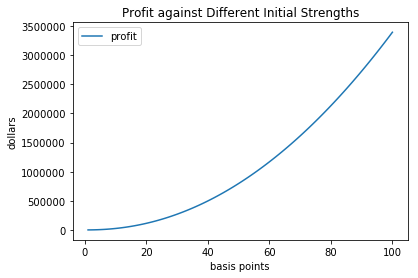

In [20]:
# Plot profit
plt.plot(forecasts, profits, label="profit")
plt.title("Profit against Different Initial Strengths")
plt.xlabel("basis points")
plt.ylabel("dollars")
plt.legend()

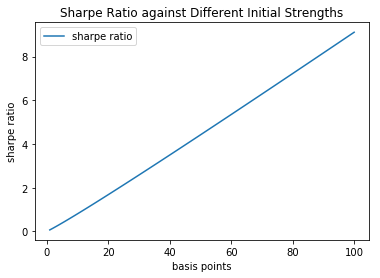

In [21]:
# Plot sparpe ratio
plt.plot(forecasts, sharpes, label="sharpe ratio")
plt.title("Sharpe Ratio against Different Initial Strengths")
plt.xlabel("basis points")
plt.ylabel("sharpe ratio")
plt.legend()

In [22]:
# Optimize against different volatilities
sigmas=np.arange(1,41)*0.001
profits=[]
sharpes=[]
for s in sigmas:
    path=optimizer(sigma=s)
    profits.append(profit(path, sigma=s))
    sharpes.append(sharpe(path, sigma=s))

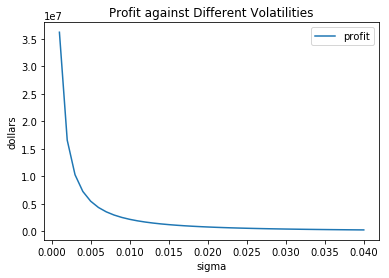

In [23]:
# Plot profit
plt.plot(sigmas, profits, label="profit")
plt.title("Profit against Different Volatilities")
plt.xlabel("sigma")
plt.ylabel("dollars")
plt.legend()

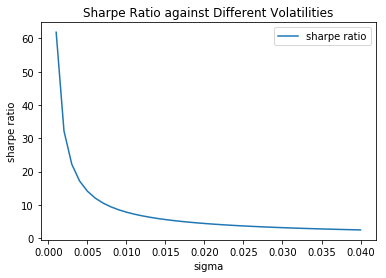

In [24]:
# Plot sparpe ratio
plt.plot(sigmas, sharpes, label="sharpe ratio")
plt.title("Sharpe Ratio against Different Volatilities")
plt.xlabel("sigma")
plt.ylabel("sharpe ratio")
plt.legend()